In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [13]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Prediction"]
y_valid = valid["Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [14]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

1988 train sequences
497 valid sequences


In [15]:
max_len = 1500

In [16]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [17]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [18]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [19]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [20]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [21]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [22]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)

In [23]:
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [24]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (1988, 1500)
x_valid shape: (497, 1500)


In [25]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [26]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

In [28]:
model = load_model('models/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.9644226951138595, 0.72635817527771]

In [29]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

In [30]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

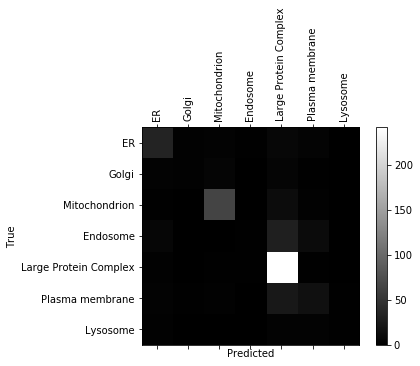

In [31]:
confusion_plot(y_valid, y_pred_label, cat)

In [32]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)

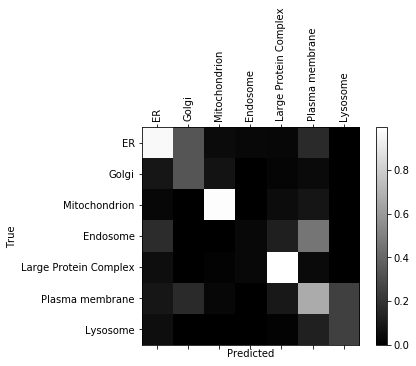

In [33]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [34]:
conf

array([[ 34,   2,   3,   1,   7,   4,   0],
       [  3,   2,   5,   0,   5,   1,   0],
       [  1,   0,  65,   0,  12,   2,   0],
       [  6,   0,   0,   1,  30,  11,   0],
       [  2,   0,   1,   1, 242,   1,   0],
       [  3,   1,   2,   0,  23,  16,   1],
       [  2,   0,   0,   0,   3,   3,   1]])

In [35]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.67      0.67      0.67        51
             Endosome       0.33      0.02      0.04        48
                Golgi       0.40      0.12      0.19        16
Large Protein Complex       0.75      0.98      0.85       247
             Lysosome       0.50      0.11      0.18         9
        Mitochondrion       0.86      0.81      0.83        80
      Plasma membrane       0.42      0.35      0.38        46

             accuracy                           0.73       497
            macro avg       0.56      0.44      0.45       497
         weighted avg       0.67      0.73      0.67       497



### Train Model 1 one mouse dataset

In [36]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

In [37]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model1_mouse_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 1988 samples, validate on 497 samples
Epoch 1/60
1988/1988 [==============================] - 213s 107ms/step - loss: 1.5324 - accuracy: 0.4889 - val_loss: 1.5062 - val_accuracy: 0.4970

Epoch 00001: val_loss improved from inf to 1.50615, saving model to models/model1_mouse_weights.hdf5
Epoch 2/60
1988/1988 [==============================] - 195s 98ms/step - loss: 1.4661 - accuracy: 0.4995 - val_loss: 1.4522 - val_accuracy: 0.4970

Epoch 00002: val_loss improved from 1.50615 to 1.45219, saving model to models/model1_mouse_weights.hdf5
Epoch 3/60
1988/1988 [==============================] - 192s 97ms/step - loss: 1.4100 - accuracy: 0.4985 - val_loss: 1.4067 - val_accuracy: 0.5292

Epoch 00003: val_loss improved from 1.45219 to 1.40671, saving model to models/model1_mouse_weights.hdf5
Epoch 4/60
1988/1988 [==============================] - 193s 97ms/step - loss: 1.3579 - accuracy: 0.5257 - val_loss: 1.3554 - val_accuracy: 0.5533

Epoch 00004: val_loss improved from 1.40671 to 1.

1988/1988 [==============================] - 314s 158ms/step - loss: 0.8060 - accuracy: 0.7384 - val_loss: 1.0285 - val_accuracy: 0.6821

Epoch 00038: val_loss did not improve from 1.00530
Epoch 39/60
1988/1988 [==============================] - 313s 158ms/step - loss: 0.7888 - accuracy: 0.7414 - val_loss: 1.0643 - val_accuracy: 0.6781

Epoch 00039: val_loss did not improve from 1.00530
Epoch 40/60
1988/1988 [==============================] - 315s 158ms/step - loss: 0.7919 - accuracy: 0.7394 - val_loss: 1.0584 - val_accuracy: 0.6781

Epoch 00040: val_loss did not improve from 1.00530
Epoch 41/60
1988/1988 [==============================] - 313s 158ms/step - loss: 0.7852 - accuracy: 0.7399 - val_loss: 1.0238 - val_accuracy: 0.6781

Epoch 00041: val_loss did not improve from 1.00530
Epoch 42/60
1988/1988 [==============================] - 315s 158ms/step - loss: 0.7766 - accuracy: 0.7455 - val_loss: 1.0378 - val_accuracy: 0.6801

Epoch 00042: val_loss did not improve from 1.00530
Epoch 4

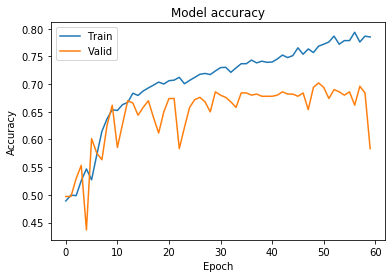

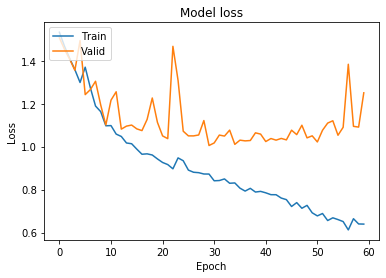

In [38]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
history_plot(history)

In [39]:
model = load_model('models/model1_mouse_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH)

497/497 [==============================] - 13s 27ms/step


[1.005297534662473, 0.6861166954040527]

In [40]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

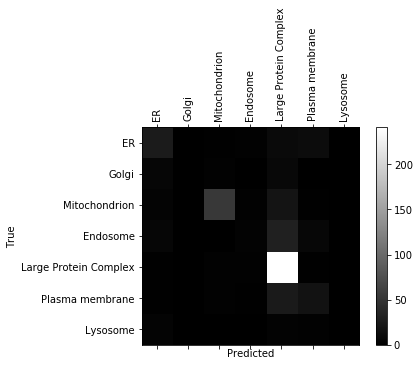

In [41]:
confusion_plot(y_valid, y_pred_label, cat)

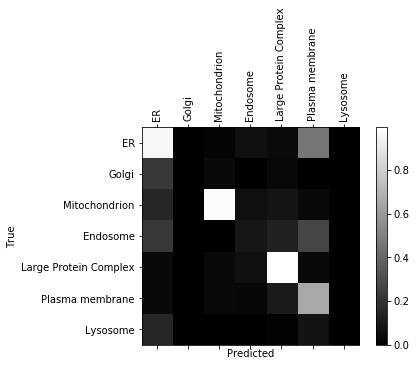

In [42]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [43]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.54      0.51      0.53        51
             Endosome       0.30      0.06      0.10        48
                Golgi       0.00      0.00      0.00        16
Large Protein Complex       0.71      0.98      0.82       247
             Lysosome       0.00      0.00      0.00         9
        Mitochondrion       0.89      0.68      0.77        80
      Plasma membrane       0.42      0.37      0.40        46

             accuracy                           0.69       497
            macro avg       0.41      0.37      0.37       497
         weighted avg       0.62      0.69      0.63       497



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
